# FUSOR Demonstrative Analysis
This notebook contains a demonstrative analysis of the FUSOR package, showing how fusion events detected from patient samples at Nationwide Children's Hospital's Institute for Genomic Medicine (IGM) can be matched to the CIViC and Molecular Oncology Almanac (MOA) databases.

The cells below are run to set environment variables and load in FUSOR.

In [1]:
from os import environ
import logging
from pathlib import Path

# These are the configurations for the UTA and SeqRepo databases. These should
# be adjusted by the user based on the locations where these databases exist.
environ["UTA_DB_URL"] = "postgresql://anonymous@localhost:5432/uta/uta_20241220"
environ["SEQREPO_ROOT_DIR"] = "/usr/local/share/seqrepo/2024-12-20"

# Cool-Seq-Tool will log warning messages for reasons including having breakpoints
# that occur outside of the transcript boundaries and having gene partners 
# that do not have MANE select transcripts. We are silencing these warning 
# messages in the output, as FUSOR objects can still be generated for these
# cases.
logging.getLogger("cool_seq_tool").setLevel(logging.ERROR)

In [2]:
from fusor.fusor import FUSOR

fusor = FUSOR()

***Using Gene Database Endpoint: http://localhost:8000***


## Prepare and Load `CategoricalFusion` Data

### CIViC

The cell below loads from the saved CIViC cache (from 12/02/25) and creates a list of `CategoricalFusion` objects. We are filtering for `accepted` and `submitted` variants from CIViC. 

In [3]:
from fusor.harvester import CIVICHarvester

harvester = CIVICHarvester(fusor=fusor, local_cache_path="data/caches/civic_cache_20251202.pkl", include_status=["accepted", "submitted"])
civic_fusions = await harvester.load_records()

ERROR:fusor.harvester:Cannot translate fusion: FGFR3(entrez:2261)::v due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion = await self.translator.translate(civic=fusion)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/translator.py", line 993, in translate
    raise ValueError(msg)
ValueError: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
ERROR:fusor.harvester:Cannot translate fusion: TCF3(entrez:6929)::PBX1(entrez:5087) due to the following reason: Translation cannot proceed as GRCh37 transcripts and exons lacks genomic breakpoints
Traceback (most recent call last):
  File "/Users/rsjxa001/fusion_project/fusor/src/fusor/harvester.py", line 412, in load_records
    cat_fusion

There are 6 fusions from CIViC that fail to translation to `CategoricalFusion` objects:
- 2 fusions (FGFR2::?) and (?::RARA) failed to translate as one of their partners is `?`, which represents an `UnknownGeneElement`. This class is restricted to `AssayedFusion` objects  
- 4 fusions fail to translate as they are missing genomic coordinates in CIViC, which is required for fusions described using GRCh37 transcripts

### MOA

The cell below loads from the saved MOA cache (10/03/25) and creates a list of `CategoricalFusion` objects.

In [4]:
from fusor.harvester import MOAHarvester

harvester = MOAHarvester(fusor=fusor, cache_dir=Path("data/caches"), use_local=True)
moa_fusions = harvester.load_records()

## Translate `AssayedFusion` objects from EnFusion files

The cell below can be run to generate a list of translated `AssayedFusion` objects from a subset of EnFusion output from 83 patient cases at IGM. This cell takes around 1.5 minutes to run. The fusion events were returned if they were detected by a combination of fusion callers including FusionMap, FusionCatcher, JAFFA, STAR-Fusion, CICERO, Arriba.

In [5]:
from fusor.harvester import EnFusionHarvester
from cool_seq_tool.schemas import Assembly
from fusor.models import AssayedFusion

logging.getLogger("fusor").setLevel(logging.CRITICAL)

harvester = EnFusionHarvester(fusor=fusor, assembly=Assembly.GRCH38)
assayed_fusions_enfusion = []
patient_ids = []
files = [patient_file.name for patient_file in Path("data/clinically-relevant-cases").iterdir() if patient_file.is_file() and patient_file.suffix == ".tsv"]

for file in files:
    fusions = await harvester.load_records(fusion_path=Path(f"data/clinically-relevant-cases/{file}"))
    fusions = [fusion for fusion in fusions if isinstance(fusion, AssayedFusion)] # We require AssayedFusion objects for matching
    for fusion in fusions:
        patient_ids.append(file)
    assayed_fusions_enfusion.extend(fusions)
f"The number of standardized fusion events is: {len(assayed_fusions_enfusion)}"

'The number of standardized fusion events is: 539'

2 fusions were unable to be translated as they are described on alternate chromosomal loci which are not suppported by FUSOR. These were **not** the clinically actionable fusions that were reported by the clinical team.

### Filter fusion events where both breakpoints occur outside of transcript boundaries
It is possible that the provided coordinates occur before the first exon or after the last exon of the provided transcripts. We would like to filter these out before running the FusionMatcher as the fusion matching module currently supports chimeric transcript fusion events, while these events may represent regulatory fusions. To do this, we use the `_validate_genomic_breakpoint` from Cool-Seq-Tool which checks if the genomic breakpoint occurs 150 bp before the first exon of the transcript or 150 bp after the last exon of the transcript.

In [6]:
from fusor.models import AssayedFusion, TranscriptSegmentElement

def extract_coord_data(tx: TranscriptSegmentElement) -> dict:
    """Extract genomic coordinate data from a `TranscriptSegmentElement`
    
    :param tx: A `TranscriptSegmentElement
    :return: A dictionary containing the genomic breakpoint, chromosomal 
        accession, and transcript accession
    """
    coord_obj = tx.elementGenomicEnd if tx.elementGenomicEnd else tx.elementGenomicStart
    coord = coord_obj.end if coord_obj.end else coord_obj.start
    chrom = coord_obj.sequenceReference.id.split(":")[1]
    trans = tx.transcript.split(":")[1]
    return {"tx": trans, "chrom": chrom, "coord": coord}

async def valid_for_fusion_matching(fusion: AssayedFusion) -> bool:
    """Check if a fusion is valid for fusion matching
    
    :fusion: An `AssayedFusion` object
    :return: `True` if both elements in the fusion structure are `GeneElements`,
        or both breakpoints fall within 150 bp of the transcript boundaries, `False` if
        not
    """
    is_valid = True
    for ele in fusion.structure:
        if isinstance(ele, TranscriptSegmentElement):
            coord_data = extract_coord_data(ele)
            bp_check = await fusor.cool_seq_tool.ex_g_coords_mapper._validate_genomic_breakpoint(pos=coord_data["coord"],
                                                                                                genomic_ac=coord_data["chrom"],
                                                                                                tx_ac=coord_data["tx"])
            if not bp_check:
                is_valid = False
                break
    return is_valid

Run the cell below to extract eligible fusions and patient IDs for fusion matching

In [7]:
valid_list = [await valid_for_fusion_matching(fusion) for fusion in assayed_fusions_enfusion]
assayed_fusions_enfusion = [fusion for fusion, valid in zip(assayed_fusions_enfusion, valid_list) if valid]
patient_ids = [patient for patient, valid in zip(patient_ids, valid_list) if valid]

# Validate that the number of patient IDs equals the number of fusion events.
# This is converted to a dictionary later in the section
print(len(assayed_fusions_enfusion) == len(patient_ids))

f"The number of fusion events eligible for fusion matching is: {len(assayed_fusions_enfusion)}"

True


'The number of fusion events eligible for fusion matching is: 505'

### Convert potential genomic breakpoints to fusion junction locations
Run the following cells to convert any potential genomic breakpoints to the corresponding fusion junction locations

In [8]:
from ga4gh.vrs.models import SequenceLocation
from fusor.models import AssayedFusion, TranscriptSegmentElement
from cool_seq_tool.schemas import Strand, CoordinateType

def segment_breakpoint_exonic(seq: SequenceLocation) -> bool:
    """Determine if a location occurs on a exon
    
    :param seq: A SequenceLocation object
    :return: ``True`` if the position occurs on a exon as indicated by the
        extension, ``False`` if not
    """
    is_exonic = None
    for ext in seq.extensions:
        if ext.name == "is_exonic":
            is_exonic = ext.value
    return is_exonic

def get_breakpoint(seq: SequenceLocation, strand: Strand, offset: int) -> int:
    """Extract breakpoint from SequenceLocation object for 
    
    :param seq: A SequenceLocation object
    :return: The breakpoint
    """
    bp= seq.end if seq.end else seq.start
    return bp - offset if strand == Strand.POSITIVE else bp + offset

async def update_fusion_structure(fusion: AssayedFusion) -> AssayedFusion:
    """Update fusion to describe junction locations instead of genomic
    breakpoints
    
    :param fusion: An AssayedFusion object
    :return: An AssayedFusion object
    """
    fusion = fusion.model_copy(deep=True)
    structure = fusion.structure
    for pos, ele in enumerate(structure):
        if isinstance(ele, TranscriptSegmentElement):
            if ele.elementGenomicEnd:
                is_exonic = segment_breakpoint_exonic(ele.elementGenomicEnd)
                if not is_exonic:
                    new_seg = await fusor.transcript_segment_element(
                        tx_to_genomic_coords=False,
                        gene=ele.gene.name,
                        transcript=ele.transcript.split(":")[1],
                        genomic_ac=ele.elementGenomicEnd.sequenceReference.id.split(":")[1],
                        seg_end_genomic=get_breakpoint(ele.elementGenomicEnd,
                                                       ele.strand,
                                                       ele.exonEndOffset))
                    structure[pos] = new_seg[0]
            else:
                is_exonic = segment_breakpoint_exonic(ele.elementGenomicStart)
                if not is_exonic:
                    new_seg = await fusor.transcript_segment_element(
                        tx_to_genomic_coords=False,
                        gene=ele.gene.name,
                        transcript=ele.transcript.split(":")[1],
                        genomic_ac=ele.elementGenomicStart.sequenceReference.id.split(":")[1],
                        seg_start_genomic=get_breakpoint(ele.elementGenomicStart,
                                                       ele.strand,
                                                       ele.exonStartOffset))
                    structure[pos] = new_seg[0]
    fusion.structure = structure
    fusion.viccNomenclature = fusor.generate_nomenclature(fusion)
    return fusion

In [9]:
assayed_fusions_enfusion = [await update_fusion_structure(fusion) for fusion in assayed_fusions_enfusion]

## 1. Use `FusionMatcher` to match patient fusions against CIViC and MOA

The cell below can be run to use the `FusionMatcher` module to match the translated EnFusion output, containting patient fusion data, against CIViC and MOA. Matches are prioritized and returned according to predefined [match criteria](https://github.com/cancervariants/fusor/wiki/Fusion-Match-Classes).

In [10]:
from fusor.fusion_matching import FusionMatcher

fm = FusionMatcher(assayed_fusions=assayed_fusions_enfusion,
                   comparator_fusions=civic_fusions + moa_fusions)

matches = await fm.match_fusion()

### Create Patient Variant Dictionary
The cell below can be run to create a dictionary containing the returned matching `CategoricalFusion` objects for each patient sample.

In [11]:
from collections import defaultdict

matches_ids = []
for match, id in zip(matches, patient_ids):
    if match:
        matches_ids.append((match, id))

patient_match_dict = defaultdict(list)

for tup in matches_ids:
    obj, pid = tup
    patient_match_dict[pid].append(tup[0])
patient_match_dict = dict(patient_match_dict)

## 2. Fusion Match Characterization
The cells below analyze the results of the matching analysis, describing the types of `CategoricalFusions` matches that are returned given an `AssayedFusion` query and the types of evidence that are associated with those matches.

The helper functions below are used throughout this section:

In [12]:
from fusor.models import CategoricalFusion
from fusor.fusion_matching import MatchType
from collections import Counter

def count_match_types(matches: list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count the number of match types across a list of matching output
    
    :param matches: A list of tuples containing CategoricalFusion and MatchType 
        objects
    :return: A dictionary describing the number of fusions that belong in each 
        shared fusion match category"""
    element_counts = [match[1].priority // 10 for match in matches]
    element_counts = Counter(element_counts)
    map = {1: "exact", 2:"shared_genes_exact_one_partner", 3:"shared_genes", 
           4:"exact_one_partner", 5:"shared_gene_one_partner"}
    return {map[key]: value for key, value in element_counts.items()}

In [13]:
def count_match_types_patient(match_info: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict[str, int]:
    """Count the number of match types that occur across a patient sample
    
    :param match_info: A list of list of tuples containing the match information
        for a patient sample
    :return: A dictionary describing match information at the patient level
    """
    categories = [
        "exact",
        "shared_genes_exact_one_partner",
        "shared_genes",
        "exact_one_partner",
        "shared_gene_one_partner",
    ]
    total_counts = Counter({cat: 0 for cat in categories})
    
    for match in match_info:
        match_dat = count_match_types(match)
        total_counts.update({k: match_dat.get(k, 0) for k in categories})
    
    return dict(total_counts)

### Get highest returned priority match type across patients
The cell below reports the highest priority type that is returned for the matching `CategoricalFusions` for each patient sample.

In [14]:
highest_priority = []
for patient in patient_match_dict:
    priority = count_match_types_patient(patient_match_dict[patient])
    for key in priority:
        if priority[key] > 0:
            highest_priority.append(key)
            break

Run the cells below to visualize the highest fusion priority type that is returned for each patient sample with a matching `CategoricalFusion`.

In [15]:
import pandas as pd

match_counts = Counter(highest_priority)

columns = ["priority_type", "count"]
highest_priority_df = pd.DataFrame(columns=columns)
highest_priority_df["priority_type"] = ["exact", "shared genes exact one partner",
                                        "shared genes",  "exact one partner",
                                        "shared gene one partner"]
highest_priority_df["count"] = [match_counts["exact"], 
                                match_counts["shared_genes_exact_one_partner"],
                                match_counts["shared_genes"],
                                match_counts["exact_one_partner"],
                                match_counts["shared_gene_one_partner"]]

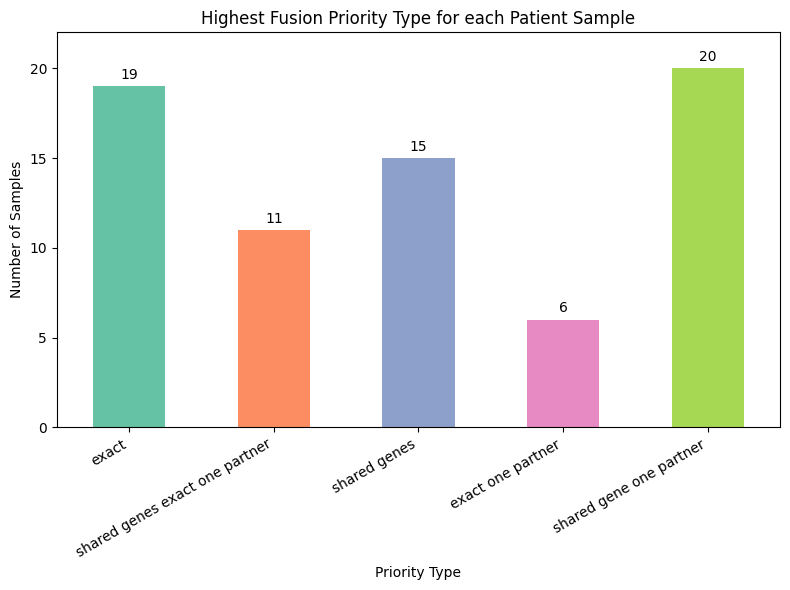

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Path("figures").mkdir(parents=True, exist_ok=True)

bar_colors = sns.color_palette("Set2")

ax = highest_priority_df.plot.bar(x="priority_type", y="count",
                                  title="Highest Fusion Priority Type for each Patient Sample",
                                  figsize=(8, 6), color=bar_colors, legend=False)
plt.xlabel("Priority Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30, ha="right")
ymax = highest_priority_df["count"].max()
ax.set_yticks(np.arange(0, ymax + 5, 5))
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.margins(x=0.05, y=0.1)
plt.tight_layout()

fig = ax.get_figure()
fig.savefig("figures/nch_fusion_matching.png", bbox_inches="tight", dpi=1000)
plt.show()

### Compute Match Type Summary Statistics
Run the cell below to compute summary statistics describing the types of matches that were returned.

In [17]:
print(f"The number of translated fusion across the {len(files)} examined patient files is: {len(assayed_fusions_enfusion)}")
print(f"The number of patient files with at least one match to CIViC or MOA is: {len(patient_match_dict)}")
print(f"The number of patient assayed fusions that had at least one match against CIViC and MOA is: {len([match for match in matches if match])}")

# Compute the number of match types across the different patient samples
priority_counts = [count_match_types_patient(patient_match_dict[patient]) for patient in patient_match_dict]
combined_counts = dict(sum((Counter(d) for d in priority_counts), Counter()))
categories = [
    "exact",
    "shared_genes_exact_one_partner",
    "shared_genes",
    "exact_one_partner",
    "shared_gene_one_partner",
]
combined_counts = {cat: combined_counts[cat] for cat in categories}
f"The breakdown of returned match types across the testing set is: {combined_counts}"

The number of translated fusion across the 83 examined patient files is: 505
The number of patient files with at least one match to CIViC or MOA is: 71
The number of patient assayed fusions that had at least one match against CIViC and MOA is: 93


"The breakdown of returned match types across the testing set is: {'exact': 19, 'shared_genes_exact_one_partner': 12, 'shared_genes': 30, 'exact_one_partner': 108, 'shared_gene_one_partner': 625}"

## 3. Clinical Evidence Comparison


The cells below are used to extract the levels of evidence (e.g. A-E) that are returned for matching `CategoricalFusion` objects from the CIViC knowledgebase.

The helper functions below are used throughout this section:

In [18]:
from civicpy.civic import MolecularProfile
from fusor.models import CategoricalFusion

def get_evidence_ratings_per_mp(mp: MolecularProfile) -> dict:
    """Get a dictionary describing evidence ratings associated with a
    MolecularProfile object

    :param mp: A MolecularProfile object
    :return: A dictionary containing the number of evidence items with a given
        rating (A-E)
    """
    ratings = [e.evidence_level for e in mp.evidence_items]
    return dict(Counter(ratings))

def aggregate_evidence_ratings(dicts: list[dict]) -> dict:
    """Helper function used to aggreate evidence rating counts
    
    :param dicts: A list of dictionaries
    :return: A dictionary with the aggregate count across the list
    """
    counter = Counter()
    for r_dict in dicts:
        counter.update(r_dict)
    counter = {k: counter.get(k, 0) for k in ["A", "B", "C", "D", "E"]}
    return dict(counter)

def aggregate_evidence_ratings_per_fusion(fusion: CategoricalFusion) -> dict:
    """Get a dictionary containing the number of times a given evidence rating
    appears across a list of MolecularProfiles associated with a fusion

    :param fusion: A CategoricalFusion object
    :return: A dictinonary describing the evidence rating counts across the
        fusion
    """
    r_dicts = [get_evidence_ratings_per_mp(mp) for mp in fusion.extensions[0].value]
    return aggregate_evidence_ratings(r_dicts)

def aggregate_evidence_ratings_per_matching_output(fusions: 
                                                   list[tuple[CategoricalFusion, MatchType]]) -> dict:
    """Count number of times evidence ratings appear across a list of matched
    CategoricalFusion objects. This is only supported for matched fusions
    from CIViC

    :param fusions: A list of tuples CategoricalFusion objects and MatchTypes
    :return: A dictionary describing the evidence rating counts across the
        lists of fusions
    """
    r_dicts = [aggregate_evidence_ratings_per_fusion(fusion[0]) for fusion
               in fusions if fusion[0].extensions[0].name == "civicMolecularProfiles"]
    return aggregate_evidence_ratings(r_dicts)

def aggregate_evidence_ratings_per_sample(matches: list[list[tuple[CategoricalFusion, MatchType]]]) -> dict:
    """Aggregate evidence rating counts at the sample level
    
    :param matches: A list containing lists of tuples of returned matching 
        CategoricalFusion objects and their MatchTypes
    :return: A dictionary containing the aggregate rating counts at the sample
        level
    """
    match_dicts = [aggregate_evidence_ratings_per_matching_output(match) for
                   match in matches]
    return aggregate_evidence_ratings(match_dicts)

### Compute the ratings of returned evidence at the patient level
Run the cell below to generate a list of dictionaries describing the returned evidence ratings for each patient sample. This output is limited to returned fusions from CIViC. It is possible for different `MolecularProfile` objects to share the same evidence IDs, so the counts below represent **aggregate** evidence ratings counts.

In [19]:
er_list = [aggregate_evidence_ratings_per_sample(patient_match_dict[sample]) for sample in patient_match_dict]

### Get highest returned evidence rating across patient samples
The cell below reports the highest CIViC evidence rating that is returned for the matching `CategoricalFusions` for each patient sample.

In [20]:
top_evidence = []
for er_dict in er_list:
    for key in er_dict:
        if er_dict[key] > 0:
            top_evidence.append(key)
            break

Run the cells below to visualize the highest returned CIViC evidence rating per patient sample

In [21]:
er_counts = Counter(top_evidence)

columns = ["evidence_rating", "count"]
er_df = pd.DataFrame(columns=columns)
er_df["evidence_rating"] = ["A", "B", "C", "D", "E"]
er_df["count"] = [er_counts["A"], er_counts["B"], er_counts["C"],
                  er_counts["D"], er_counts["E"]]

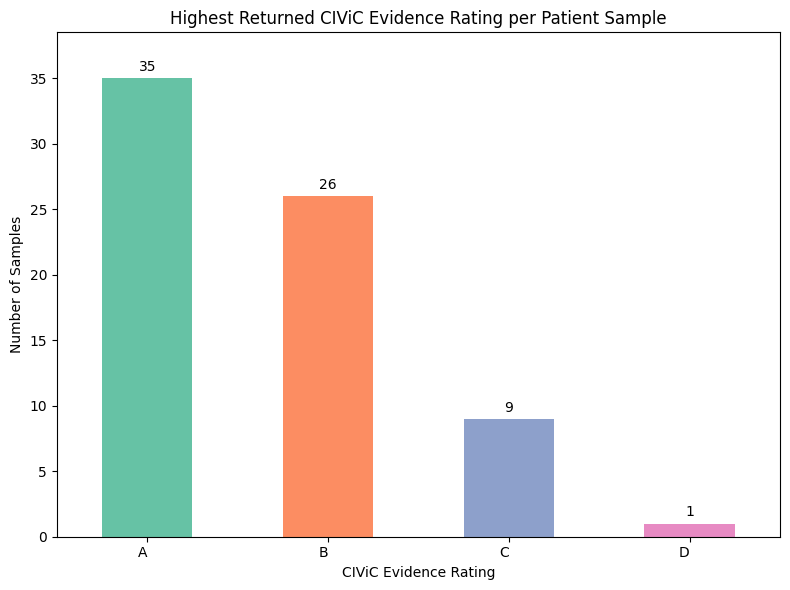

In [22]:
bar_colors = sns.color_palette("Set2")
er_df_plot = er_df[er_df["count"] > 0]

ax = er_df_plot.plot.bar(x="evidence_rating", y="count",
                                  title="Highest Returned CIViC Evidence Rating per Patient Sample",
                                  figsize=(8, 6), color=bar_colors, legend=False)
plt.xlabel("CIViC Evidence Rating")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0, ha="right")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.margins(x=0.05, y=0.1)
plt.tight_layout()

fig = ax.get_figure()
fig.savefig("figures/civic_ratings_nch.png", bbox_inches="tight", dpi=1000)
plt.show()

Run the cell below to get the aggregative CIViC evidence rating counts across the examined samples

In [23]:
combined_er_counts = dict(sum((Counter(d) for d in er_list), Counter()))
f"The breakdown of returned CIViC evidence ratings across the {len(patient_match_dict)} samples with matches is: {combined_er_counts}"

"The breakdown of returned CIViC evidence ratings across the 71 samples with matches is: {'A': 149, 'B': 732, 'C': 996, 'D': 816, 'E': 19}"